In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("complete_hinglish_sentiment.csv")  # your file name here
print("Dataset shape:", df.shape)

# Select text and labels
X = df["hinglish_clean"].astype(str)
y = df["label_encoded"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Dataset shape: (9002, 5)


In [22]:
df.head()

,en,hinglish,label,hinglish_clean,label_encoded
0,Batman vs Superman,batman vs superman,neutral,batman vs superman,1
1,"The director is Zack Snyder , 27 % Rotten Toma...","Zack Snyder director हैं , 27 % Rotten Tomatoe...",neutral,zack snyder director हैं rotten tomatoes,1
2,Not very popular it seems,लगता है बहुत popular नहीं है,negative,लगता है बहुत popular नहीं है,0
3,But the audiences liked it . It has a B cinema...,"but audience ने like किया , इसका cinema score ...",positive,but audience ने like किया इसका cinema score भी है,2
4,Yes,yes,neutral,yes,1


In [23]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# -------------------------------
# navie bayes Baseline
# -------------------------------
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

acc_nb = accuracy_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb, average='macro')

print("\n🔹 Naive Bayes Results")
print("Accuracy:", round(acc_nb, 4))
print("F1-score (macro):", round(f1_nb, 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))




🔹 Naive Bayes Results
Accuracy: 0.6952
F1-score (macro): 0.49

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.01      0.03       147
           1       0.68      0.81      0.74       887
           2       0.71      0.69      0.70       767

    accuracy                           0.70      1801
   macro avg       0.80      0.51      0.49      1801
weighted avg       0.72      0.70      0.67      1801



In [24]:
# --------------------------------------------------------
# 4LSTM Model Evaluation
# --------------------------------------------------------
# Load trained LSTM model and tokenizer
import numpy as np
model = load_model("lstm_hinglish_sentiment.keras", compile=False)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Ensure same sequence length used in training
max_len = 50  # replace with your training max_len value

# Tokenize & pad test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Evaluate on test data
loss, acc_lstm = model.evaluate(X_test_pad, y_test, verbose=0)
y_pred_probs = model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_probs, axis=1)
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [28]:
results = pd.DataFrame({
    "Model": ["Naive Bayes", "LSTM (Deep Learning)"],
    "Accuracy": [acc_nb, acc_lstm],
    "F1-score": [f1_nb, f1_lstm]
})

print("\n Model Comparison Summary")
print(results)


 Model Comparison Summary
                  Model  Accuracy  F1-score
0           Naive Bayes  0.695169  0.490027
1  LSTM (Deep Learning)  0.747363  0.630982


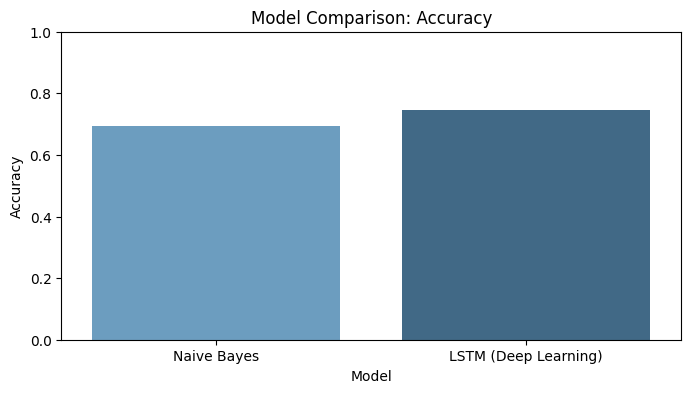

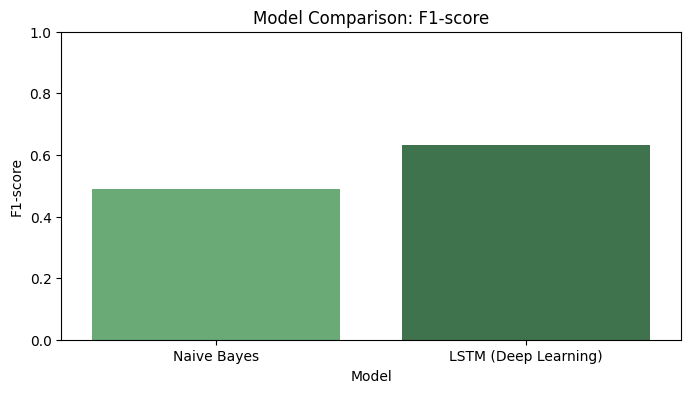


 Comparison complete. LSTM vs Baselines successfully evaluated.


In [27]:
plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="Accuracy", data=results, palette="Blues_d")
plt.title("Model Comparison: Accuracy")
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="Model", y="F1-score", data=results, palette="Greens_d")
plt.title("Model Comparison: F1-score")
plt.ylim(0, 1)
plt.show()

print("\n Comparison complete. LSTM vs Baselines successfully evaluated.")